# ResNet Architecture

### Author: Josh Hudziak
***
### Date: 30/04/21
***
### Purpose:
* The end goal of this project was to create a fully autonomously navigating UAV using a CNN (Convolutional Neural Network).

## Installation On Windows

* Anaconda:
    Download anaconda: https://www.anaconda.com/products/individual
    * Initiate anaconda shell and enter these commands to create a new environment called tensorflow
        1. conda install -y jupyter
        2. conda create --name tensorflow
        3. conda activate tensorflow

* CUDDN (for nvidia GPUs only):
    Follow Windows instructions on
    https://tensorflow.org/install/gpu
    **(Make sure to check software compatabilities)**

* Tensorflow:
    * While in the tensorflow virtual environment made earlier, run:
        1. pip install tensorflow
* Sklearn:
    * pip install sklearn
    
* Pickle:
    * pip install pickle

* Numpy:
    * pip install numpy

* matplotlib:
    * pip install matplotlib
    
* imutils:
    * pip install imutils

* wandb:
    * pip install wandb

### Importing the libraries

In [1]:
##TensorFlow library, Implement Deep learning
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math
%matplotlib inline

import numpy as np
from skimage import io
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
import pickle
from sklearn.metrics import classification_report


from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto(allow_soft_placement=False)
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
##Keras API, helps implement Data-Preprocessing

import wandb
from wandb.keras import WandbCallback
wandb.init(config={"hyper": "parameter"})

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jhudz (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [2]:
##TensorFlow version
tf.__version__

'2.1.0'

## Data Preprocessing

### Preprocessing the Training set

In [3]:
##Image Augmentation to prevent overfitting, when train set outperforms test set
# create generator to standardize images

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range=0.2
                                  ) ##transformation, preventing overfitting

##Import Dataset
##flow_from_directory connects dataset to Augmentation
train_set = train_datagen.flow_from_directory(
    ##Path
    'Dataset/train',
    ##Image Size to be fed in
    target_size=(250, 250),
    ##How many images in Batch 
    batch_size=128,
    color_mode='rgb',
    shuffle=True, 
    ##Binary or Categorical
    class_mode='categorical')

Found 43200 images belonging to 3 classes.


### Preprocessing the Test set

In [4]:
##Test Data should not be formatted, just resized as this is how it will work in real situation
test_datagen = ImageDataGenerator(rescale=1./255)

##Import Test Dataset
##flow_from_directory connects dataset to Augmentation
##Keep testing parameters the same size as training
test_set = test_datagen.flow_from_directory(
    ##Path
    'Dataset/val',
    ##Image Size to be fed in
    target_size=(250, 250),
    color_mode='rgb',
    shuffle=False,
    ##How many images in Batch 
    batch_size=128,
    ##Binary or Categorical
    class_mode='categorical')

Found 5259 images belonging to 3 classes.


In [5]:
# prepare an iterators to scale images
print('Batches train=%d, test=%d' % (len(train_set), len(test_set)))

Batches train=338, test=42


In [6]:
x_train,y_train = train_set.next()
x_train.shape

(128, 250, 250, 3)

In [7]:
x_test,y_test = test_set.next()
x_test.shape
y_test.shape

(128, 3)

In [8]:
print('Train', x_train.min(), x_train.max(), x_train.mean(), x_train.std())
print('Test', x_test.min(), x_test.max(), x_test.mean(), x_test.std())

Train 0.0 1.0 0.4576142 0.22969629
Test 0.0 1.0 0.39653262 0.2520817


### Image array example

C:\Users\Josh\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


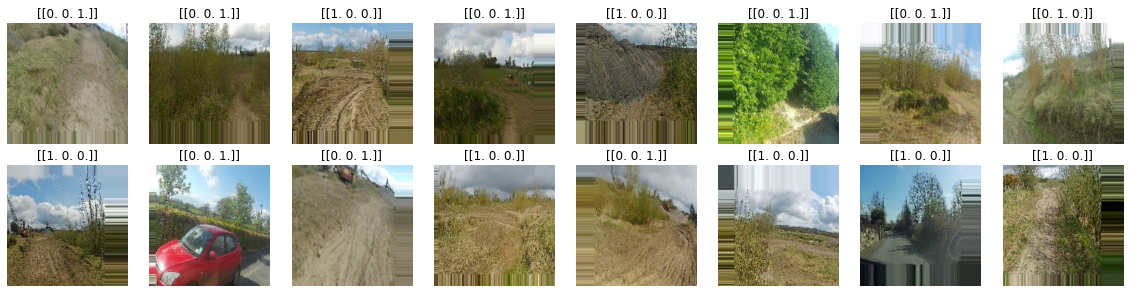

In [9]:
def show_grid(image_list,nrows,ncols,label_list,show_labels=True,savename=None,figsize=(20,10),showaxis='on'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(label_list[[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')
        
show_grid(x_train,2,8,label_list=y_train,figsize=(20,10),savename='../../Images/image_grid_ALLeven.png')

## The ResNet Model

The ResNet works in blocks, this network passes an identity from each block to the next to increase generalisation and combat overfitting.

After the final block, the result is passed into a flatten function to create a linear array of probabilities, the result of this is passed through a Relu Activation function and finally passed to a Dense network function that uses the softmax activation which separates the classification categories into their respective output as a fully connected network

In [10]:
def resnet8(img_width, img_height, img_channels, output_dim):
    """    
    # Arguments
       img_width:  image width.
       img_height: image height.
       img_channels: image channels.
       output_dim: Dimension of model output.
    # Returns
       model: A Model instance.
    """

    # Input
    img_input = Input(shape=(img_height, img_width, img_channels))

    x1 = Conv2D(16, (7, 7), strides=[3,3], padding='same')(img_input)
    x1 = MaxPooling2D(pool_size=(3, 3), strides=[1,1])(x1)

    # 1st res block
    x2 = BatchNormalization()(x1)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(16, (3, 3), strides=[3,3], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x2)

    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(16, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x2)

    x1 = Conv2D(16, (1, 1), strides=[3,3], padding='same')(x1)
    #Skip connection
    x3 = Add()([x1, x2])

    # 2nd res block
    x4 = BatchNormalization()(x3)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(32, (3, 3), strides=[3,3], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x4)

    x4 = BatchNormalization()(x4)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(32, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x4)

    x3 = Conv2D(32, (1, 1), strides=[3,3], padding='same')(x3)
    #Skip connection
    x5 = Add()([x3, x4])

    # 3rd res block
    x6 = BatchNormalization()(x5)
    x6 = Activation('relu')(x6)
    x6 = Conv2D(64, (3, 3), strides=[3,3], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x6)

    x6 = BatchNormalization()(x6)
    x6 = Activation('relu')(x6)
    x6 = Conv2D(64, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x6)

    x5 = Conv2D(64, (1, 1), strides=[3,3], padding='same')(x5)
    #Skip connection
    x7 = Add()([x5, x6])
    
    # 4th res block
    x8 = BatchNormalization()(x7)
    x8 = Activation('relu')(x8)
    x8 = Conv2D(128, (3, 3), strides=[3,3], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x8)

    x8 = BatchNormalization()(x8)
    x8 = Activation('relu')(x8)
    x8 = Conv2D(128, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x8)

    x7 = Conv2D(128, (1, 1), strides=[3,3], padding='same')(x7)
    #Skip connection
    x9 = Add()([x7, x8])

    x = Flatten()(x9)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # Output probability
    steer = Dense(output_dim, activation='softmax')(x)

    # Define the model
    model = Model(inputs=[img_input], outputs=steer) #add call
    #print(model.summary())

    return model

## Training the Model

### Compiling the model

In [11]:
resNet = resnet8(250,250,3,3)
##Connect CNN to optimiser and loss function
##Accuraccy metrics to measure CNN
resNet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#tf.keras.utils.plot_model(cnn, to_file='model_1.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 84, 84, 16)   2368        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 82, 82, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 82, 82, 16)   64          max_pooling2d[0][0]              
______________________________________________________________________________________________

### Training the Model on the Training set and Evaluating it on the Test set

In [12]:
#Early Stopping
#es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4)
#Save the best Model
mc = ModelCheckpoint('MODELS/Gun.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#Fit
ResNet_H = resNet.fit(x = train_set, validation_data = test_set, epochs=30, callbacks=[mc, WandbCallback()], workers=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 338 steps, validate for 42 steps
Epoch 1/30
337/338 [============================>.] - ETA: 0s - loss: 0.2606 - accuracy: 0.9378
Epoch 00001: val_accuracy improved from -inf to 0.93041, saving model to ../../MODELS/Gun.h5
338/338 [==============================] - 467s 1s/step - loss: 0.2602 - accuracy: 0.9379 - val_loss: 0.4527 - val_accuracy: 0.9304
Epoch 2/30
337/338 [============================>.] - ETA: 1s - loss: 0.1324 - accuracy: 0.9845
Epoch 00002: val_accuracy did not improve from 0.93041
338/338 [==============================] - 486s 1s/step - loss: 0.1323 - accuracy: 0.9846 - val_loss: 0.8326 - val_accuracy: 0.8454
Epoch 3/30
337/338 [============================>.] - ETA: 1s - loss: 0.1107 - accuracy: 0.9901
Epoch 00003: val_accuracy did not improve from 0.93041
338/338 [==============================] - 489s 1s/step - loss: 0.1108 - accuracy: 0.9900 - val_loss: 2.7066 - val_accuracy: 0.5927
Epoch 4/30
337/338 [

337/338 [============================>.] - ETA: 0s - loss: 0.0338 - accuracy: 0.9972
Epoch 00028: val_accuracy improved from 0.97509 to 0.97623, saving model to ../../MODELS/Gun.h5
338/338 [==============================] - 477s 1s/step - loss: 0.0338 - accuracy: 0.9972 - val_loss: 0.1134 - val_accuracy: 0.9762
Epoch 29/30
337/338 [============================>.] - ETA: 0s - loss: 0.0349 - accuracy: 0.9967
Epoch 00029: val_accuracy did not improve from 0.97623
338/338 [==============================] - 471s 1s/step - loss: 0.0349 - accuracy: 0.9966 - val_loss: 0.9348 - val_accuracy: 0.8768
Epoch 30/30
337/338 [============================>.] - ETA: 0s - loss: 0.0352 - accuracy: 0.9968
Epoch 00030: val_accuracy did not improve from 0.97623
338/338 [==============================] - 467s 1s/step - loss: 0.0352 - accuracy: 0.9968 - val_loss: 1.8646 - val_accuracy: 0.7579


### Save the best model

In [13]:
#cnn.save('../../MODELS/ResNet_V7.h5')
model = tf.keras.models.load_model("MODELS/Gun.h5")


## Evaluate overall performance

In [14]:
test_loss, test_acc = model.evaluate(test_set, verbose=1)
print('\nTest accuaracy: ', test_acc)

  ...
    to  
  ['...']
42/42 [==============================] - 125s 3s/step - loss: 0.1134 - accuracy: 0.9762

Test accuaracy:  0.9762312


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[INFO] evaluating network...


C:\Users\Josh\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      centre       1.00      0.91      0.95       128
        left       0.00      0.00      0.00         0
       right       0.00      0.00      0.00         0

    accuracy                           0.91       128
   macro avg       0.33      0.30      0.32       128
weighted avg       1.00      0.91      0.95       128



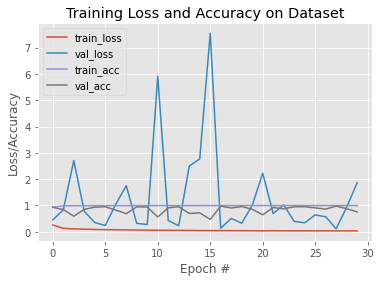

In [15]:

#Evaluate the results of the data using the testdatset.

    #Using matplotlib
#    **Redundant as using Weights and Biases Library to Evaluate Results while processing.
    
lb = pickle.loads(open('../../MODELS/lb.pickle', "rb").read())
print(ResNet_H.history.keys())

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=x_test.astype("float32"), batch_size=1)
print(classification_report(y_test.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))
# plot the training loss and accuracy
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), ResNet_H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), ResNet_H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), ResNet_H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), ResNet_H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('Images/Latest.png')


## Test on Single Predictions

In [16]:
labels = {0 : 'centre',
          1 : 'left',
          2 : 'right'}

def predict_img(path) :
    img = tf.keras.preprocessing.image.load_img(path,target_size=(250,250))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = np.array([img])
    print(model.predict(img))
    pred = labels[np.argmax(model.predict(img))]
    plt.imshow(img.reshape(250,250,1))
    plt.title(pred)


predict_img('Dataset/val/left/right frame_35displace_5630.jpg')   

FileNotFoundError: [Errno 2] No such file or directory: '../../_data/left/202001frame_10365.jpg'